# Anomaly Detection of trading volumes in cryptocurrency exchanges
Luca Santarella - University of Pisa - 21/07/2023

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from pycoingecko import CoinGeckoAPI
import tensorflow as tf
import plotly.express as px
import numpy as np
import os

## Load csv file
Reading the CSV file containing the hourly trading volumes for the exchanges examined.

In [26]:
df_ts = pd.read_csv('df_ts_hourly.csv')

In [27]:
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts = df_ts[:9162]
df_ts.drop_duplicates(subset=["Date"], inplace=True)
df_ts = df_ts.sort_values('Date')
df_ts = df_ts.set_index('Date')

In [28]:
df_ts

,bigone,binance,binance_us,bitbank,bitfinex,bitflyer,bithumb,bitkub,bitmart,bitmax,...,mxc,nice_hash,nominex,okcoin,okex,paribu,phemex,poloniex,upbit,whitebit
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-30 02:00:00,8.287416e+08,1.922943e+10,4.916869e+08,8.018211e+07,1.094849e+09,1.940224e+08,1.009429e+09,1.595830e+08,9.334052e+08,1.109217e+08,...,7.870450e+08,2.535662e+06,4.701200e+07,2.935919e+07,6.414763e+09,1.427097e+08,2.009041e+08,1.075168e+08,3.011602e+09,7.185201e+08
2021-12-30 03:00:00,8.312725e+08,1.918313e+10,4.953903e+08,8.407951e+07,1.096519e+09,1.963390e+08,1.028204e+09,1.578217e+08,9.511104e+08,1.108921e+08,...,7.915098e+08,2.659276e+06,2.473111e+07,3.149856e+07,6.444872e+09,1.431770e+08,2.008007e+08,1.083290e+08,3.014962e+09,7.217614e+08
2021-12-30 04:00:00,8.300331e+08,1.924655e+10,4.937685e+08,8.742569e+07,1.103147e+09,1.983776e+08,1.050803e+09,1.581658e+08,9.488360e+08,1.107057e+08,...,7.967678e+08,2.695192e+06,2.338190e+07,3.131168e+07,6.433327e+09,1.430071e+08,2.007838e+08,1.080876e+08,3.004383e+09,7.253918e+08
2021-12-30 05:00:00,8.233821e+08,1.916242e+10,4.903539e+08,8.449887e+07,1.098388e+09,1.964561e+08,1.066694e+09,1.567372e+08,9.387266e+08,1.105155e+08,...,7.968534e+08,2.761498e+06,2.314612e+07,3.118567e+07,6.413763e+09,1.434263e+08,1.998085e+08,1.070083e+08,2.972236e+09,7.246463e+08
2021-12-30 06:00:00,8.243425e+08,1.908838e+10,4.930256e+08,8.782274e+07,1.107546e+09,2.002056e+08,1.059873e+09,1.559400e+08,9.372808e+08,1.111707e+08,...,8.190350e+08,2.766384e+06,2.315815e+07,3.136238e+07,6.460936e+09,1.420628e+08,2.005630e+08,1.045777e+08,2.877831e+09,7.285476e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-14 21:00:00,5.782532e+08,2.978445e+10,6.401099e+08,3.118141e+07,2.662602e+08,5.849104e+07,3.941324e+08,6.622921e+07,1.187854e+09,9.610456e+07,...,1.232573e+09,3.328370e+05,2.460324e+07,2.564029e+07,1.996198e+09,1.851940e+08,1.765479e+08,5.158282e+07,4.529511e+09,2.010236e+09
2023-01-14 22:00:00,5.693171e+08,2.917279e+10,6.328162e+08,2.999100e+07,2.600653e+08,5.776348e+07,3.824055e+08,6.444717e+07,1.164709e+09,9.546271e+07,...,1.216693e+09,3.187717e+05,2.507622e+07,2.555775e+07,1.945817e+09,1.827481e+08,1.707110e+08,4.937478e+07,4.529710e+09,1.986100e+09
2023-01-14 23:00:00,5.517744e+08,2.812019e+10,6.269519e+08,2.802339e+07,2.552417e+08,5.740709e+07,3.739694e+08,6.115761e+07,1.135644e+09,9.364383e+07,...,1.193563e+09,3.378910e+05,2.565928e+07,2.505916e+07,1.898919e+09,1.757342e+08,1.641727e+08,4.863690e+07,4.169650e+09,1.937809e+09


Creating a baseline composed of the average of the trading volumes of "trusted" exchanges

In [4]:
df_ts['baseline'] = df_ts[['kraken','bitfinex','gemini','bitstamp','gdax']].mean(axis=1)

In [5]:
df_baseline = df_ts[['baseline']].copy()
df_baseline

,baseline
Date,
2021-12-30 02:00:00,1.433660e+09
2021-12-30 03:00:00,1.445814e+09
2021-12-30 04:00:00,1.456434e+09
2021-12-30 05:00:00,1.464606e+09
2021-12-30 06:00:00,1.477919e+09
...,...
2023-01-14 21:00:00,7.160195e+08
2023-01-14 22:00:00,6.966562e+08
2023-01-14 23:00:00,6.753450e+08


In [6]:
all_ex = df_ts.columns.to_list()
print(all_ex)

['bigone', 'binance', 'binance_us', 'bitbank', 'bitfinex', 'bitflyer', 'bithumb', 'bitkub', 'bitmart', 'bitmax', 'bitrue', 'bitstamp', 'bkex', 'btcturk', 'bybit_spot', 'coinex', 'coinsbit', 'coin_metro', 'crypto_com', 'dextrade', 'digifinex', 'gate', 'gdax', 'gemini', 'huobi', 'kraken', 'kucoin', 'latoken', 'lbank', 'luno', 'mxc', 'nice_hash', 'nominex', 'okcoin', 'okex', 'paribu', 'phemex', 'poloniex', 'upbit', 'whitebit', 'baseline']


In [52]:
df_dict = {}
for ex_id in all_ex:
    df_tmp = df_ts[[ex_id]].copy()
    df_tmp.rename(columns={ex_id: "value"}, inplace=True)
    df_dict[ex_id] = df_tmp
    

In [8]:
df_dict['kraken']

,value
Date,
2021-12-30 02:00:00,1.239627e+09
2021-12-30 03:00:00,1.231726e+09
2021-12-30 04:00:00,1.230654e+09
2021-12-30 05:00:00,1.233398e+09
2021-12-30 06:00:00,1.223959e+09
...,...
2023-01-14 21:00:00,4.804094e+08
2023-01-14 22:00:00,4.645066e+08
2023-01-14 23:00:00,4.453851e+08


In [10]:
def scale_data(df):
    scaler = MinMaxScaler()
    df_training_value = df.copy()
    scaled_values = scaler.fit_transform(df)
    df_training_value['value'] = scaled_values
    return df_training_value

In [11]:
TIME_STEPS = 24

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [12]:
def create_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss="mse")
    #model.summary()
    return model

In [13]:
def fit_model(x_train, model):
    history = model.fit(
        x_train,
        x_train,
        epochs=100,
        batch_size=128,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
        ],
        verbose=0
    )
    return history

In [14]:
def plot_learning_curve(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [15]:
def plot_reconstruction(x_train, x_train_pred):
    # Checking how the first sequence is learnt
    plt.plot(x_train[300], label="Actual trading volume")
    plt.plot(x_train_pred[300], label="Reconstructed trading volume")
    plt.legend()
    plt.show()

baseline

512
percentage of anomalies: 2.941819772528434





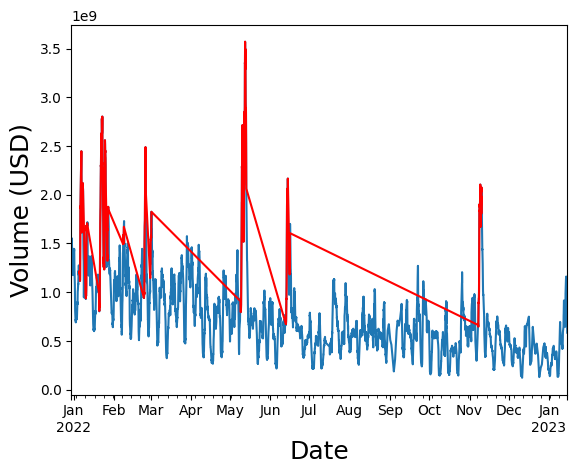

<Figure size 1500x1000 with 0 Axes>

In [16]:
#all_ex = df_ts.columns.to_list()
all_ex = ['baseline']

for ex_id in all_ex:
    df_train = df_dict[ex_id][:240]
    print(ex_id+'\n')
    training_mean = df_train.mean()
    training_std = df_train.std()
    df_training_value = (df_train - training_mean) / training_std
    
    x_train = create_sequences(df_training_value.values)
    model = create_model()
    history = fit_model(x_train, model)
    #plot_learning_curve(history)
    
    # Get train MAE loss.
    x_train_pred = model.predict(x_train, verbose=0)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

#     plt.hist(train_mae_loss, bins=50)
#     plt.xlabel("Train MAE loss")
#     plt.ylabel("No of samples")
#     plt.show()

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    
    #plot_reconstruction(x_train, x_train_pred)
#     fig, ax = plt.subplots()
#     df_dict[ex_id].plot(legend=False, ax=ax)
#     plt.show()

    # Create sequences from test values.
    training_mean = df_dict[ex_id].mean()
    training_std = df_dict[ex_id].std()
    df_test_value = (df_dict[ex_id] - training_mean) / training_std
    x_test = create_sequences(df_test_value.values)
    #print(x_test[0])
    #print("Test input shape: ", x_test.shape)

    # Get test MAE loss.
    x_test_pred = model.predict(x_test, verbose=0)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

#     plt.hist(test_mae_loss, bins=50)
#     plt.xlabel("test MAE loss")
#     plt.ylabel("No of samples")
#     plt.show()

    # Detect all the samples which are anomalies.
    anomalies = test_mae_loss > threshold 
    print(anomalies.sum())
    #print("Number of anomaly samples: ", np.sum(anomalies))
    #print("Indices of anomaly samples: ", np.where(anomalies))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data_indices = []
    for data_idx in range(TIME_STEPS - 1, len(df_dict[ex_id]) - TIME_STEPS + 1):
        if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    perc_anomalies = len(anomalous_data_indices)/len(df_dict[ex_id]/TIME_STEPS)*100
    print(f"percentage of anomalies: {perc_anomalies}\n\n\n")
    
    if (perc_anomalies > 0):
        df_subset = df_dict[ex_id].iloc[np.where(anomalies)]
        fig, ax = plt.subplots()
        df_dict[ex_id].plot(legend=False, ax=ax)
        df_subset.plot(legend=False, ax=ax, color="r")
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Volume (USD)', fontsize=18)
        params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
        plt.rcParams.update(params)
        fig.savefig('plot.jpg')
        plt.figure(figsize=(15,10))
        plt.show()

In [17]:
anomalies_baseline = anomalies
anomalous_data_indices_baseline = anomalous_data_indices

bigone

314
percentage of anomalies: 0.7874015748031495





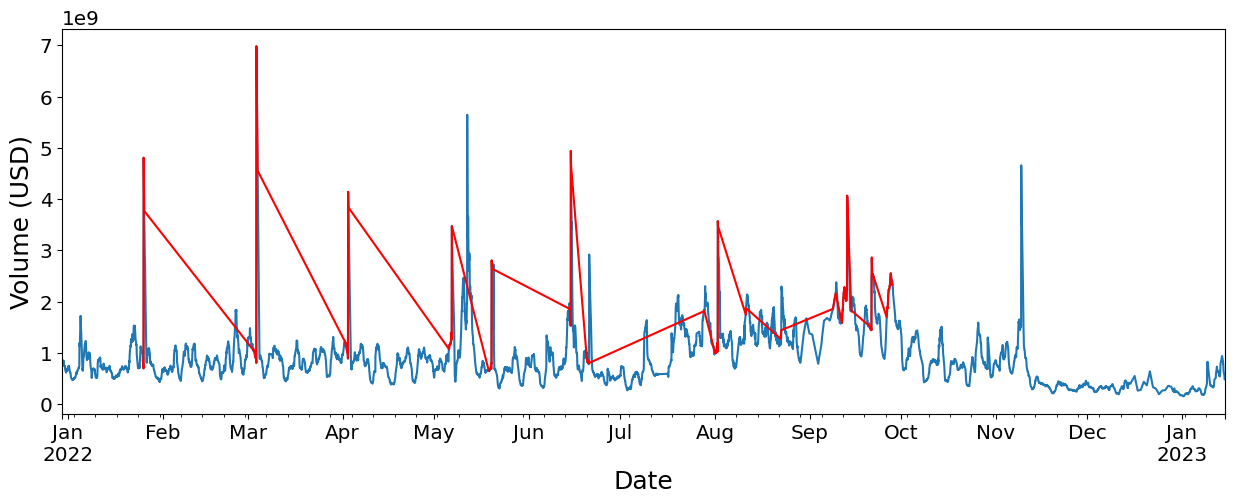

<Figure size 1500x1000 with 0 Axes>

binance

24
percentage of anomalies: 0.0



binance_us

107
percentage of anomalies: 0.2405949256342957





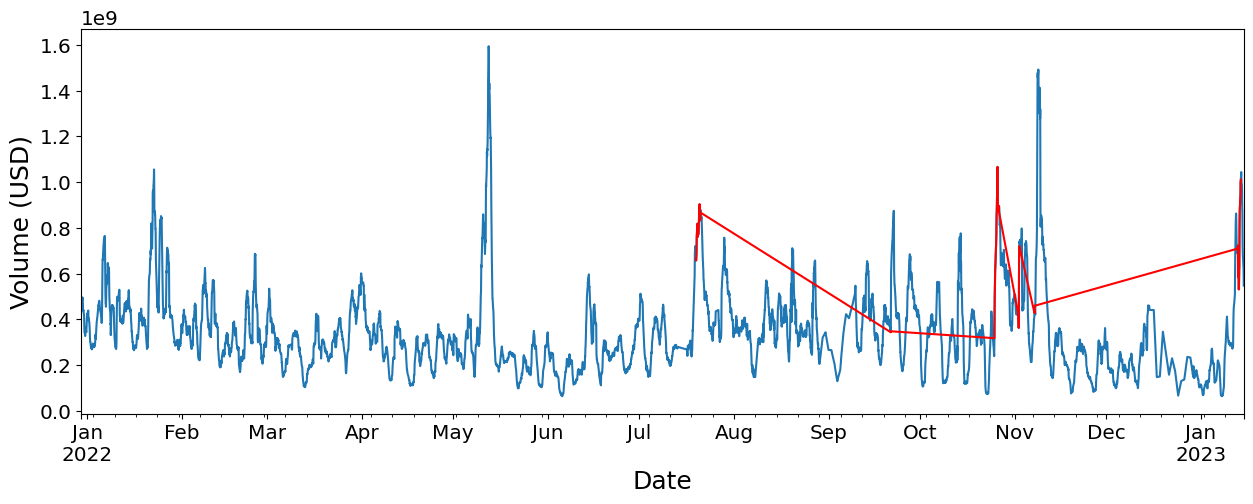

<Figure size 1500x1000 with 0 Axes>

bitbank

33
percentage of anomalies: 0.03280839895013123





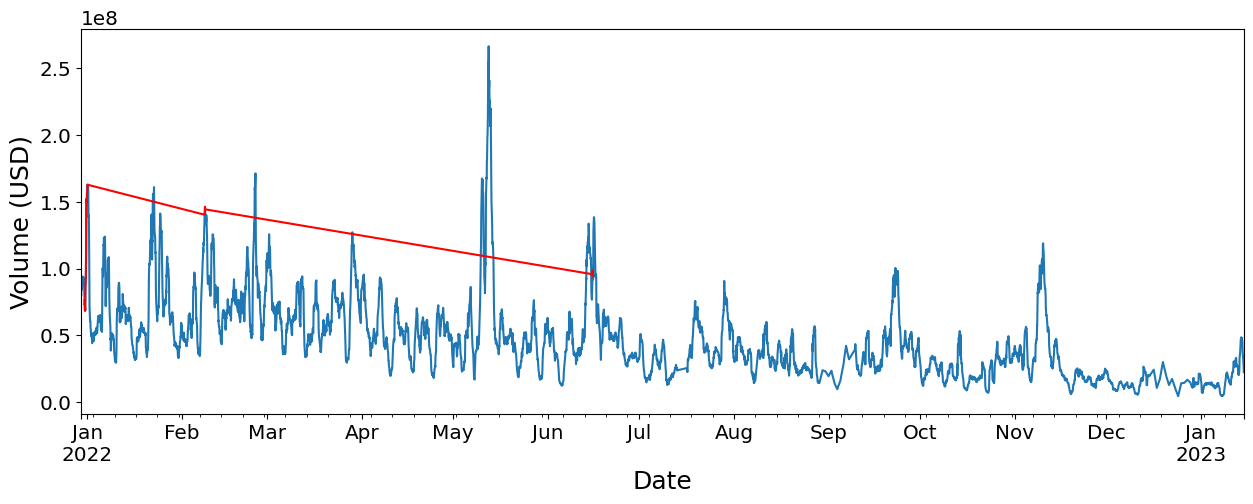

<Figure size 1500x1000 with 0 Axes>

bitfinex

118
percentage of anomalies: 0.36089238845144356





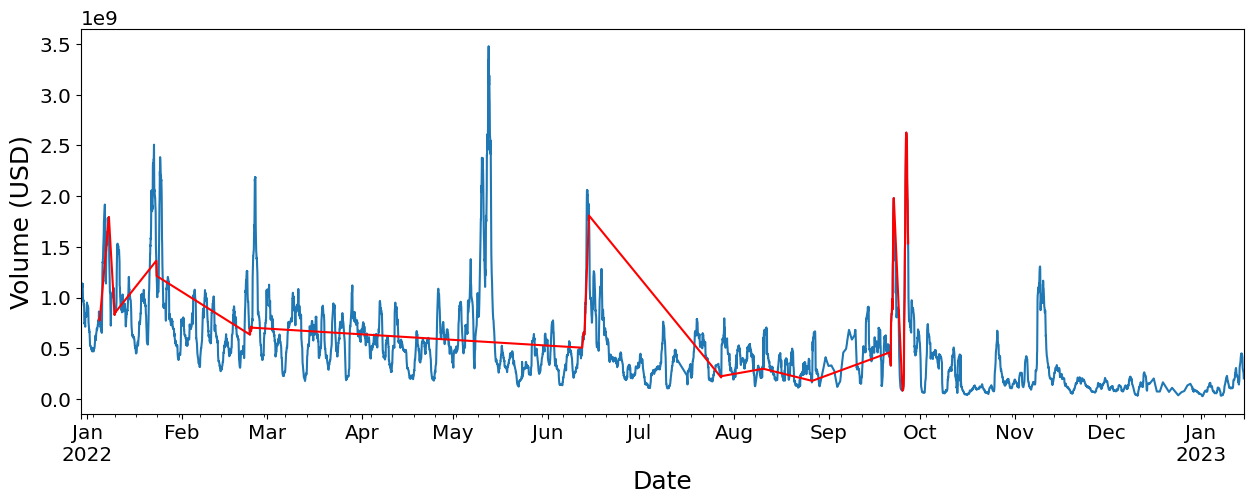

<Figure size 1500x1000 with 0 Axes>

bitflyer

193
percentage of anomalies: 0.19685039370078738





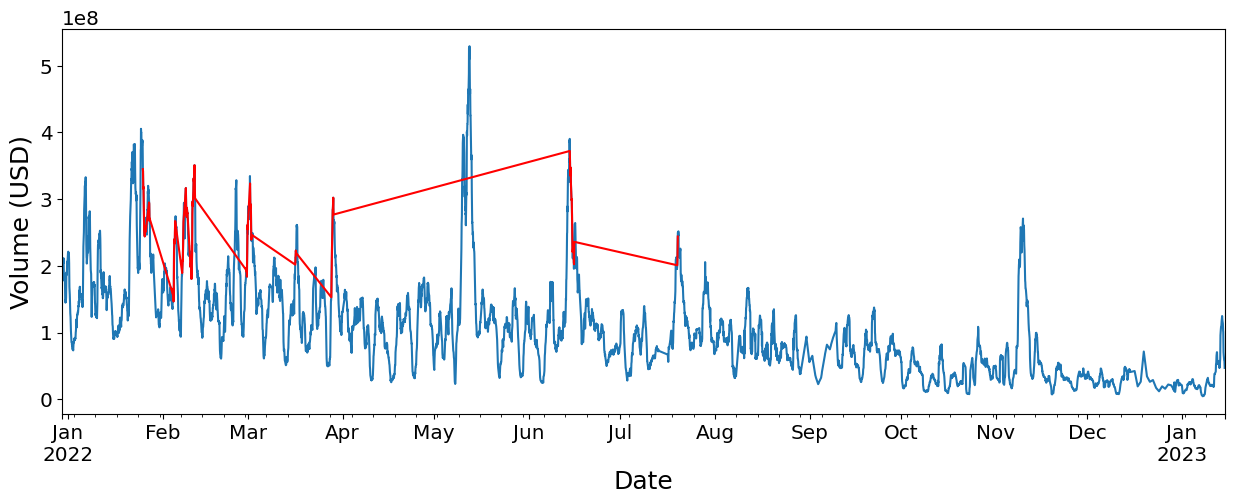

<Figure size 1500x1000 with 0 Axes>

bithumb

208
percentage of anomalies: 1.1592300962379702





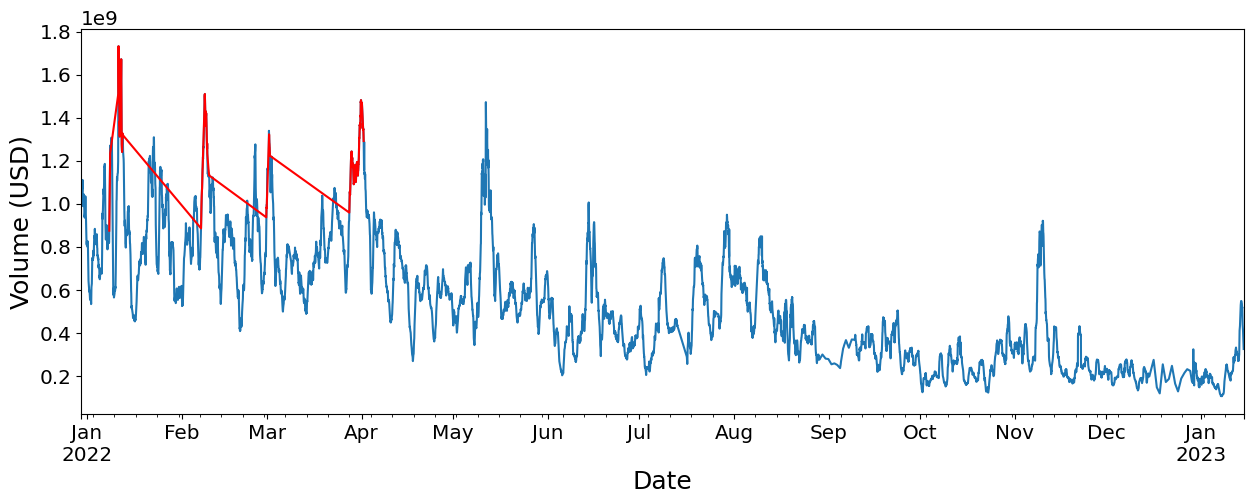

<Figure size 1500x1000 with 0 Axes>

bitkub

268
percentage of anomalies: 1.9028871391076114





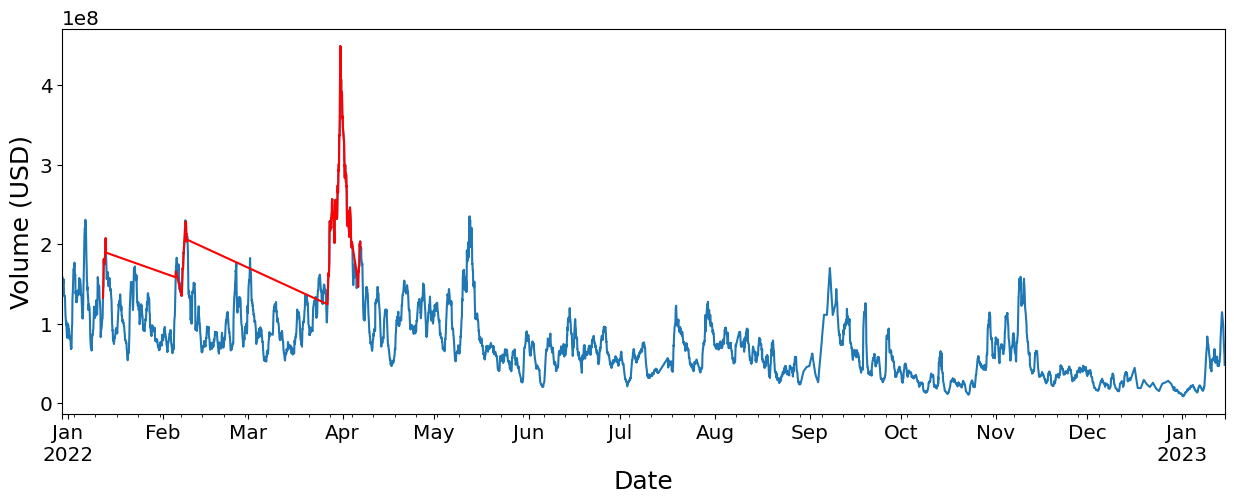

<Figure size 1500x1000 with 0 Axes>

bitmart

162
percentage of anomalies: 0.8967629046369203





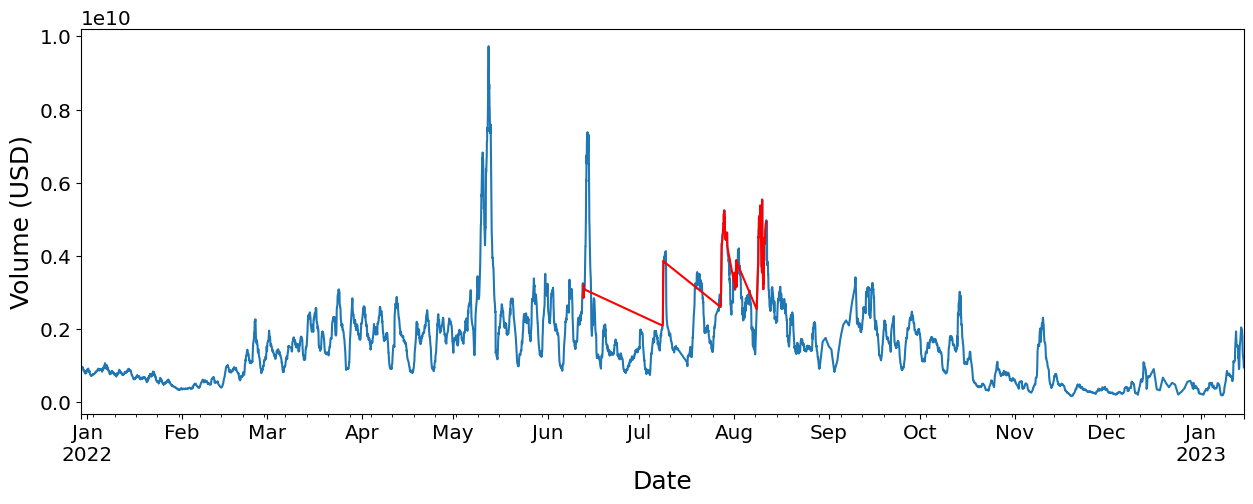

<Figure size 1500x1000 with 0 Axes>

bitmax

18
percentage of anomalies: 0.0



bitrue

126
percentage of anomalies: 0.6342957130358705





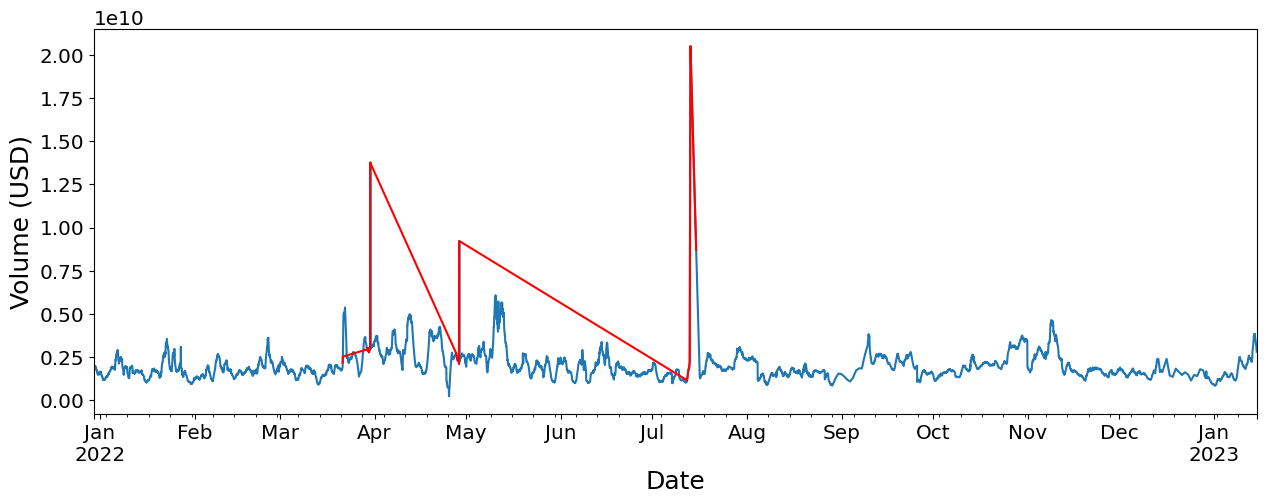

<Figure size 1500x1000 with 0 Axes>

bitstamp

9
percentage of anomalies: 0.0



bkex

50
percentage of anomalies: 0.30621172353455817





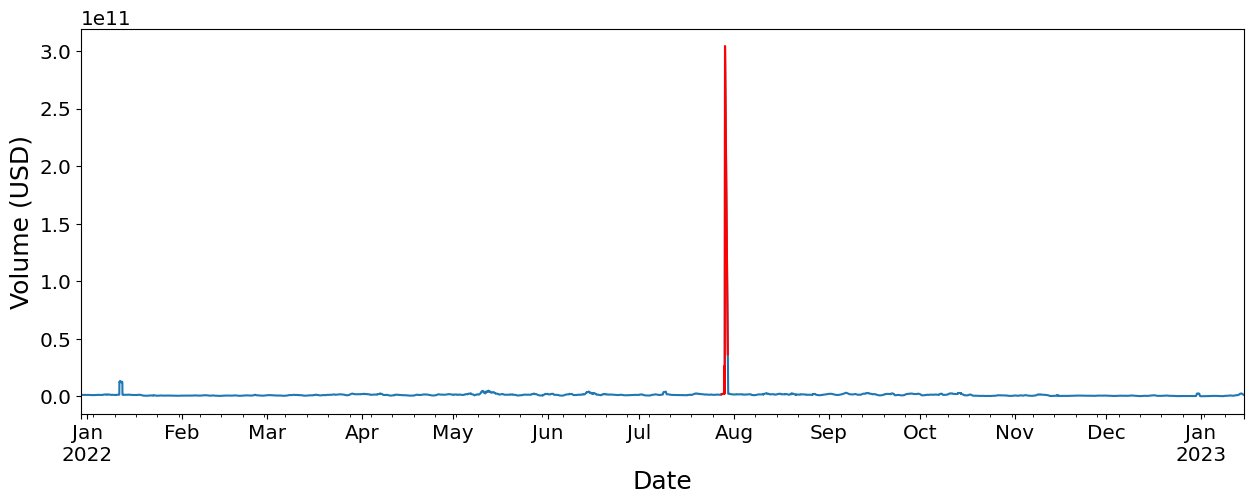

<Figure size 1500x1000 with 0 Axes>

btcturk

232
percentage of anomalies: 1.4107611548556431





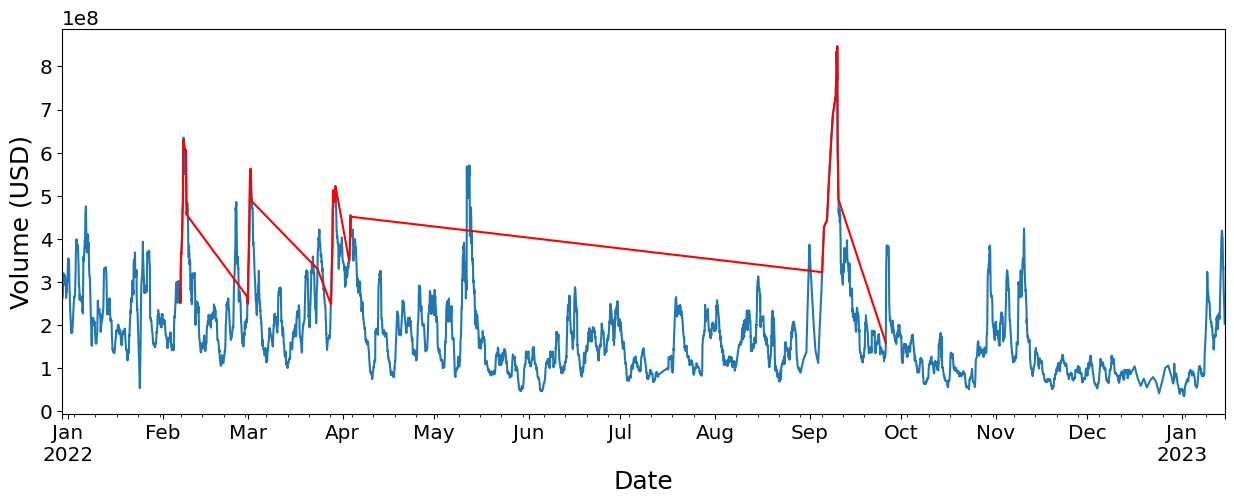

<Figure size 1500x1000 with 0 Axes>

bybit_spot

99
percentage of anomalies: 0.42650918635170604





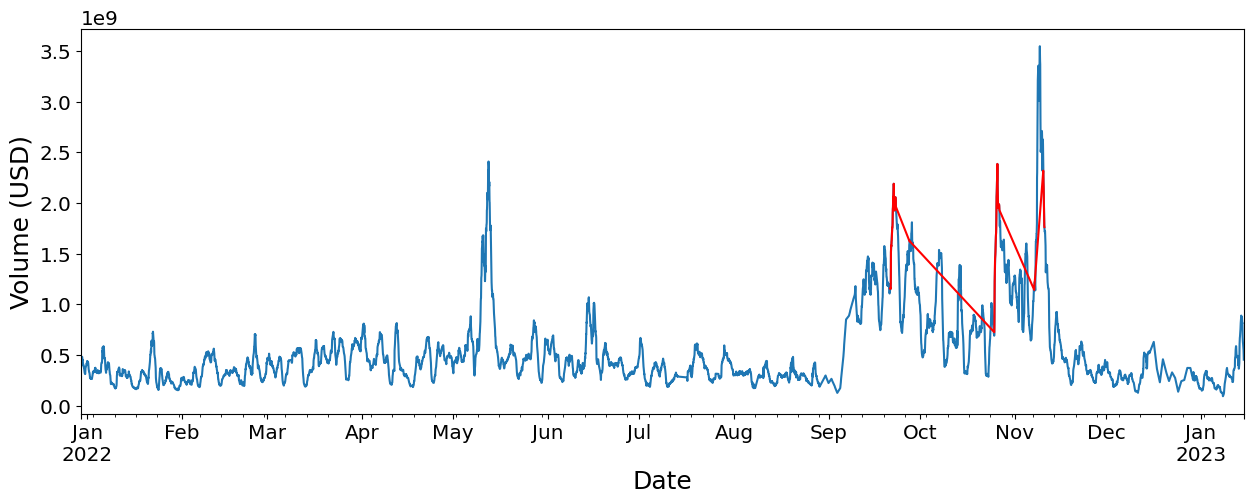

<Figure size 1500x1000 with 0 Axes>

coinex

4
percentage of anomalies: 0.0



coinsbit

11
percentage of anomalies: 0.0



coin_metro

243
percentage of anomalies: 1.0608048993875765





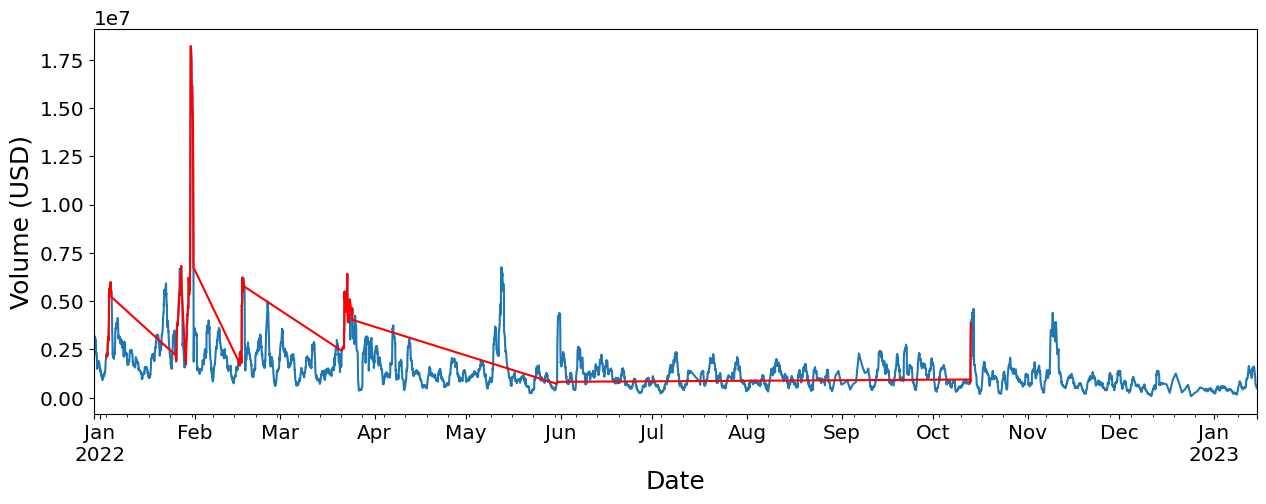

<Figure size 1500x1000 with 0 Axes>

crypto_com

14
percentage of anomalies: 0.0



dextrade

248
percentage of anomalies: 0.7874015748031495





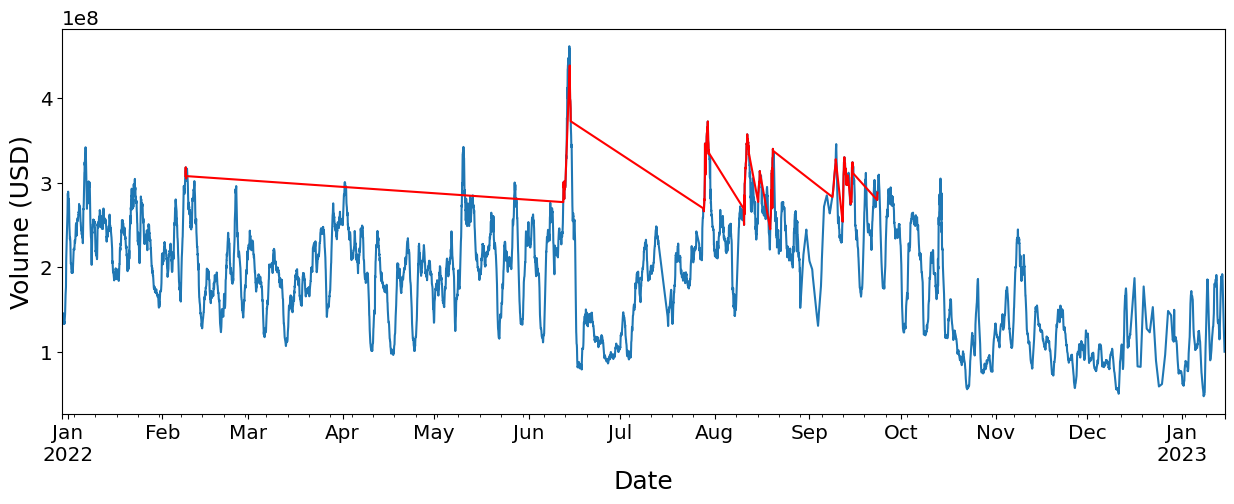

<Figure size 1500x1000 with 0 Axes>

digifinex

54
percentage of anomalies: 0.3499562554680665





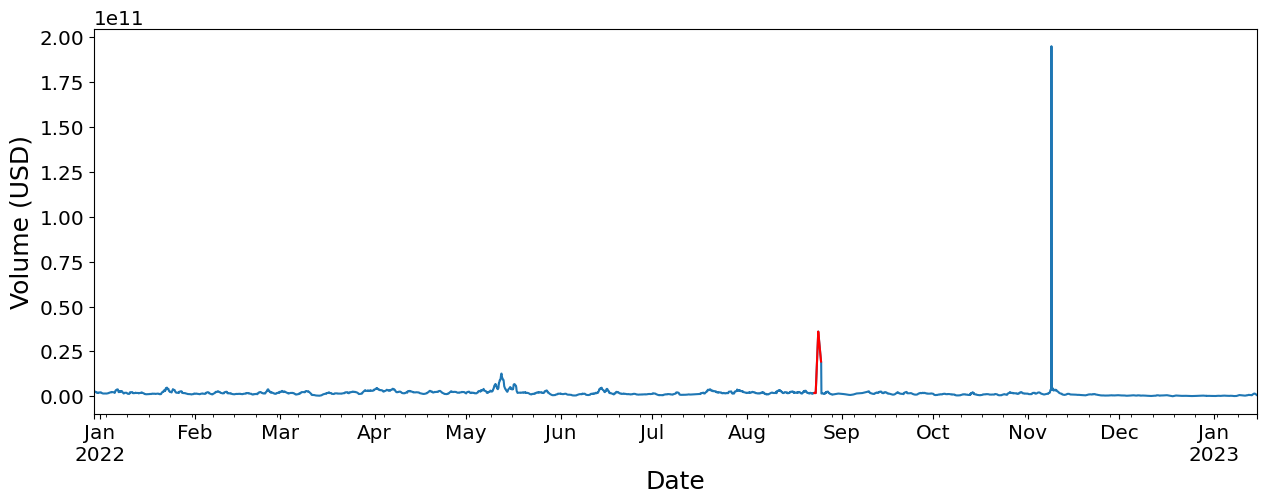

<Figure size 1500x1000 with 0 Axes>

gate

104
percentage of anomalies: 0.31714785651793526





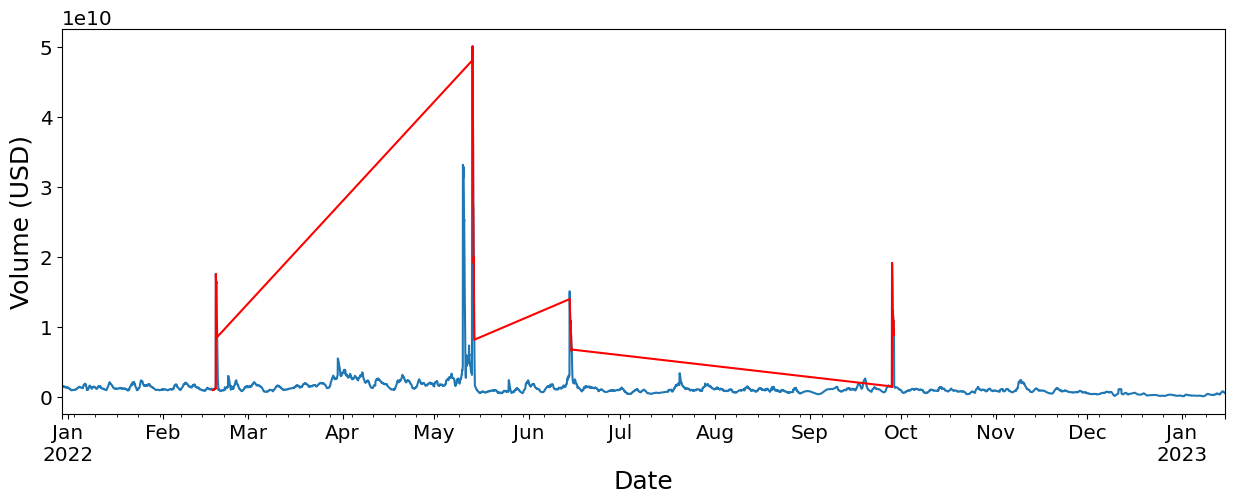

<Figure size 1500x1000 with 0 Axes>

gdax

3
percentage of anomalies: 0.0



gemini

41
percentage of anomalies: 0.0



huobi

5
percentage of anomalies: 0.0



kraken

18
percentage of anomalies: 0.0



kucoin

52
percentage of anomalies: 0.06561679790026247





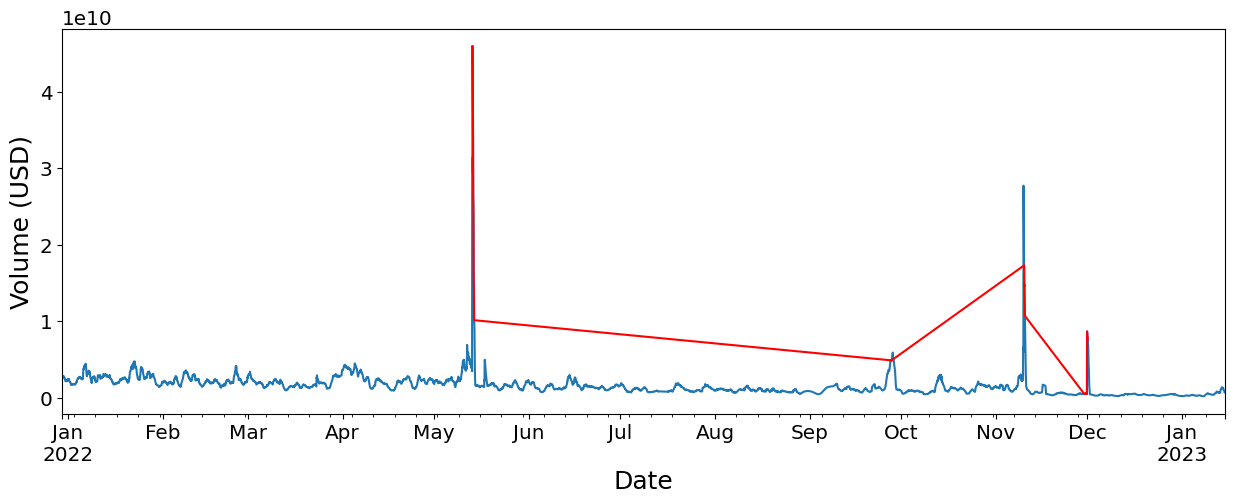

<Figure size 1500x1000 with 0 Axes>

latoken

510
percentage of anomalies: 4.330708661417323





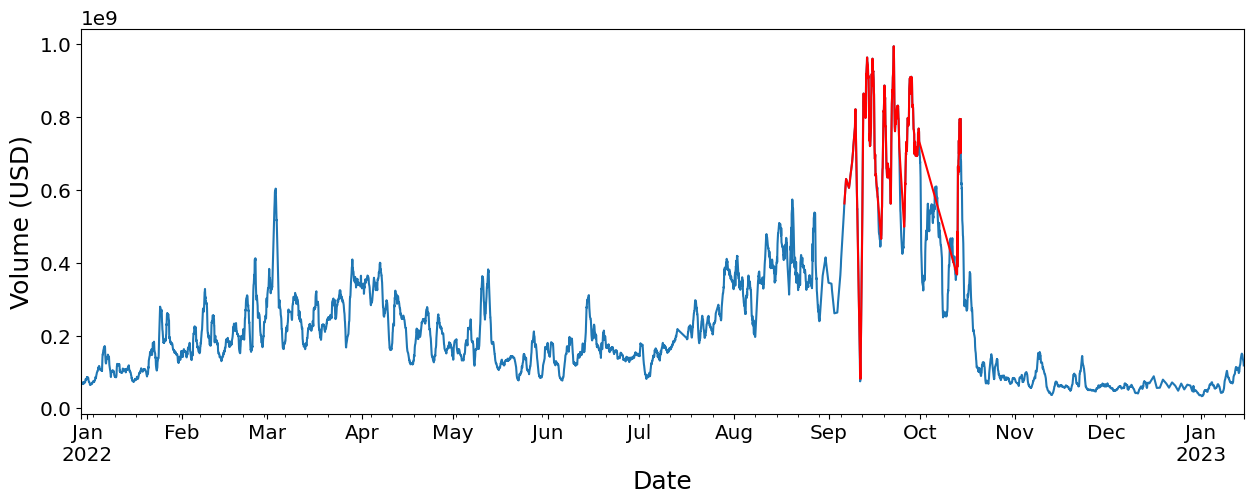

<Figure size 1500x1000 with 0 Axes>

lbank

57
percentage of anomalies: 0.17497812773403326





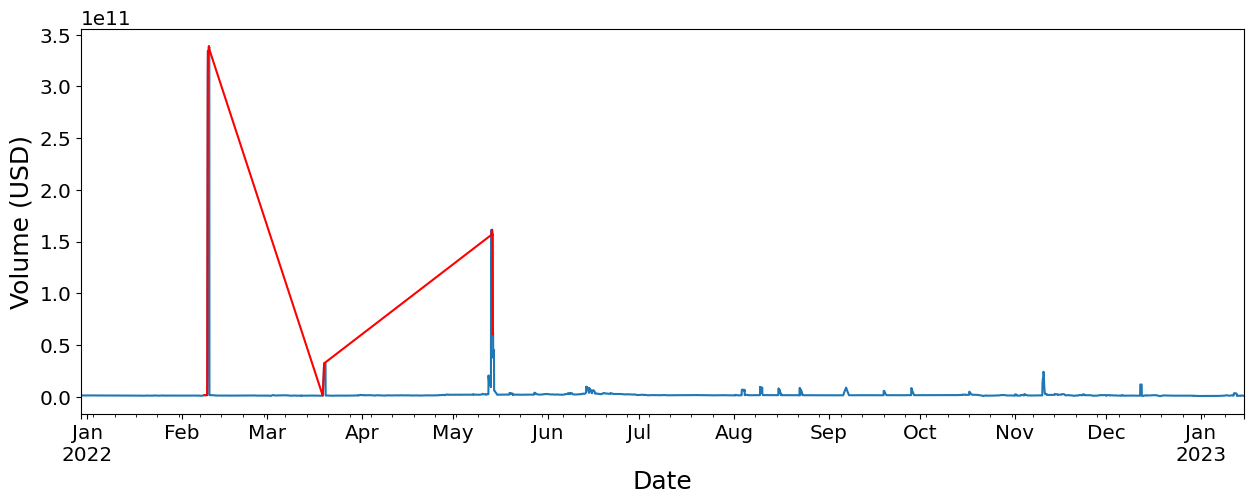

<Figure size 1500x1000 with 0 Axes>

luno

146
percentage of anomalies: 0.010936132983377079





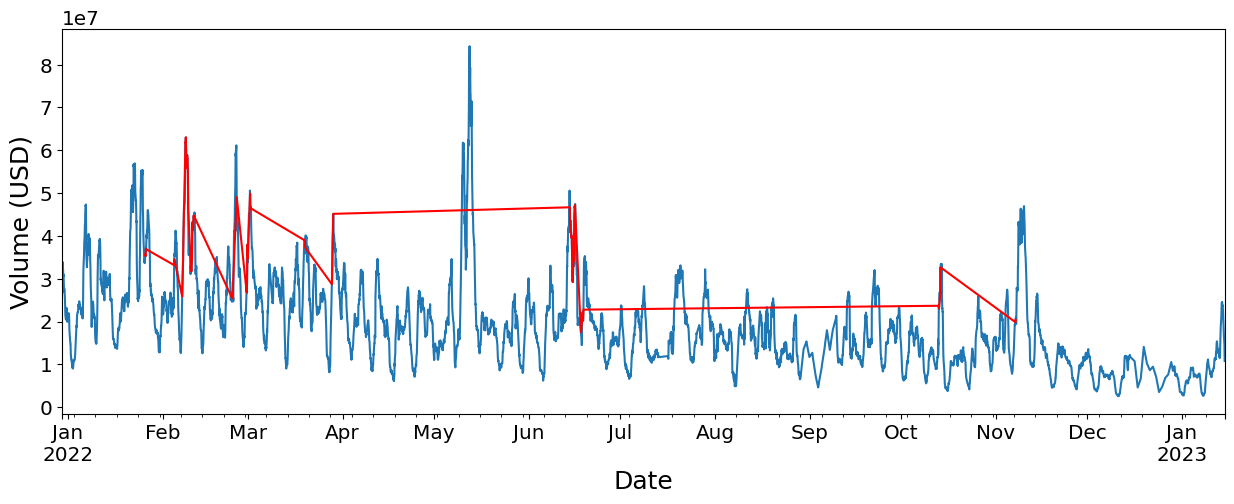

<Figure size 1500x1000 with 0 Axes>

mxc

152
percentage of anomalies: 0.37182852143482065





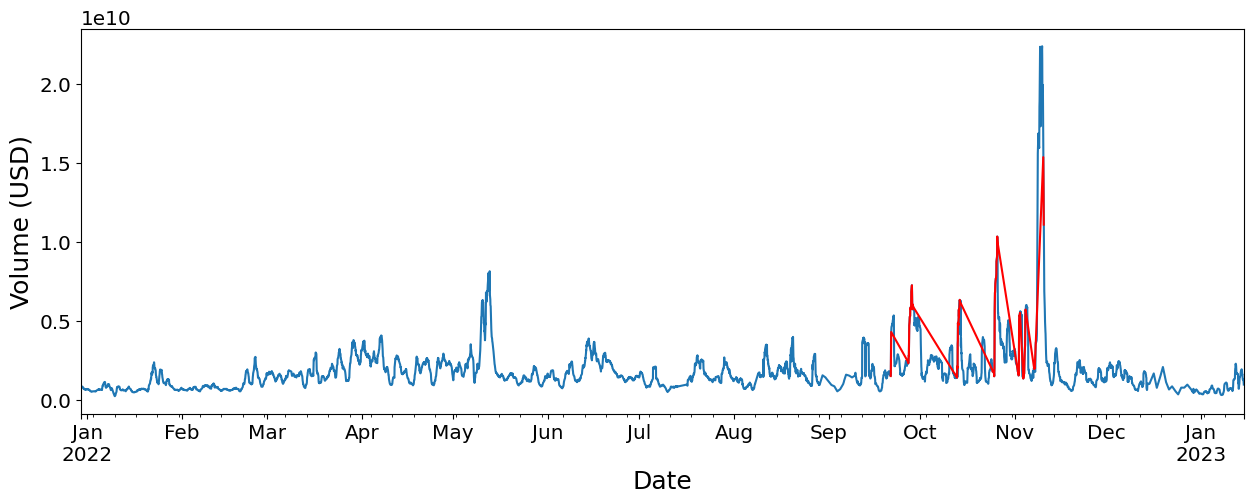

<Figure size 1500x1000 with 0 Axes>

nice_hash

162
percentage of anomalies: 0.5249343832020997





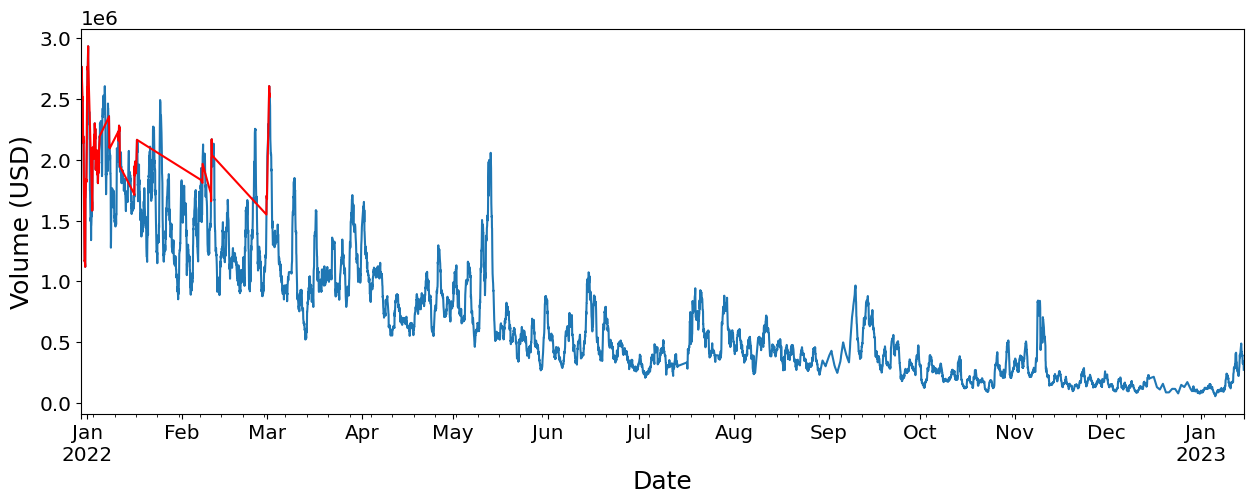

<Figure size 1500x1000 with 0 Axes>

nominex

147
percentage of anomalies: 0.7983377077865266





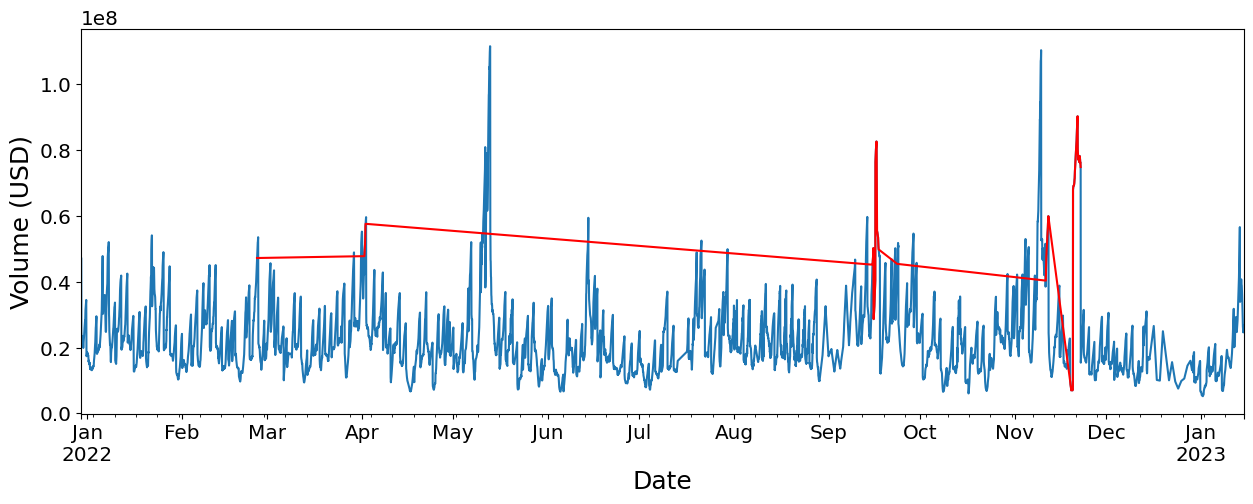

<Figure size 1500x1000 with 0 Axes>

okcoin

21
percentage of anomalies: 0.0



okex

45
percentage of anomalies: 0.21872265966754156





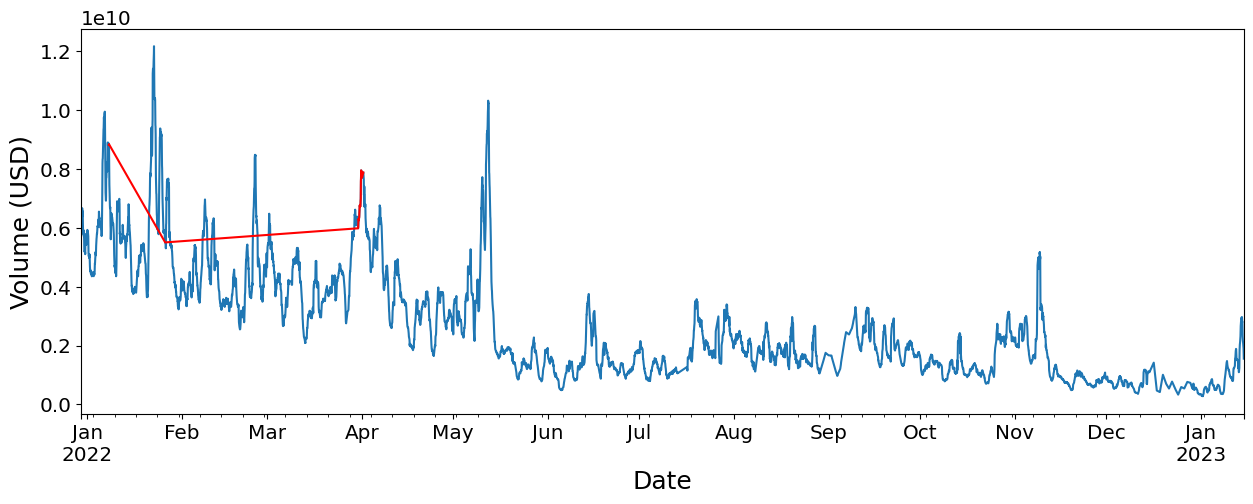

<Figure size 1500x1000 with 0 Axes>

paribu

333
percentage of anomalies: 1.4326334208223972





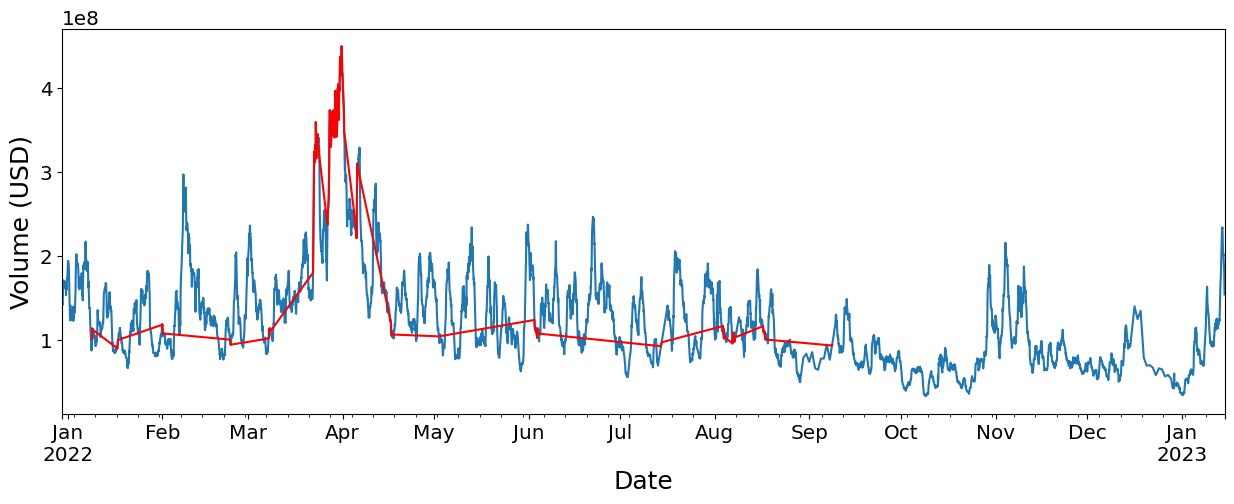

<Figure size 1500x1000 with 0 Axes>

phemex

229
percentage of anomalies: 2.0013123359580054





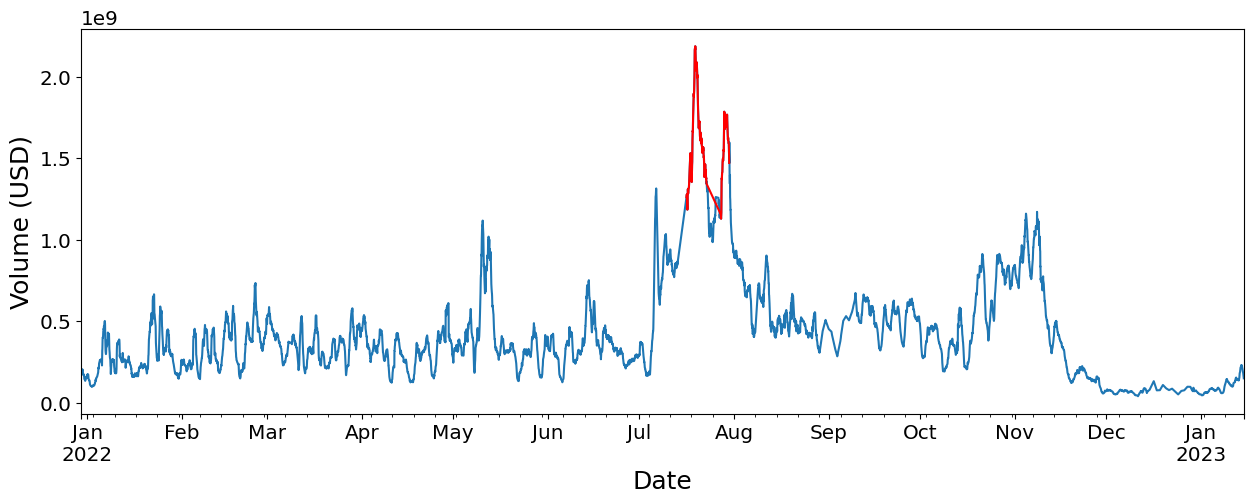

<Figure size 1500x1000 with 0 Axes>

poloniex

168
percentage of anomalies: 0.41557305336832895





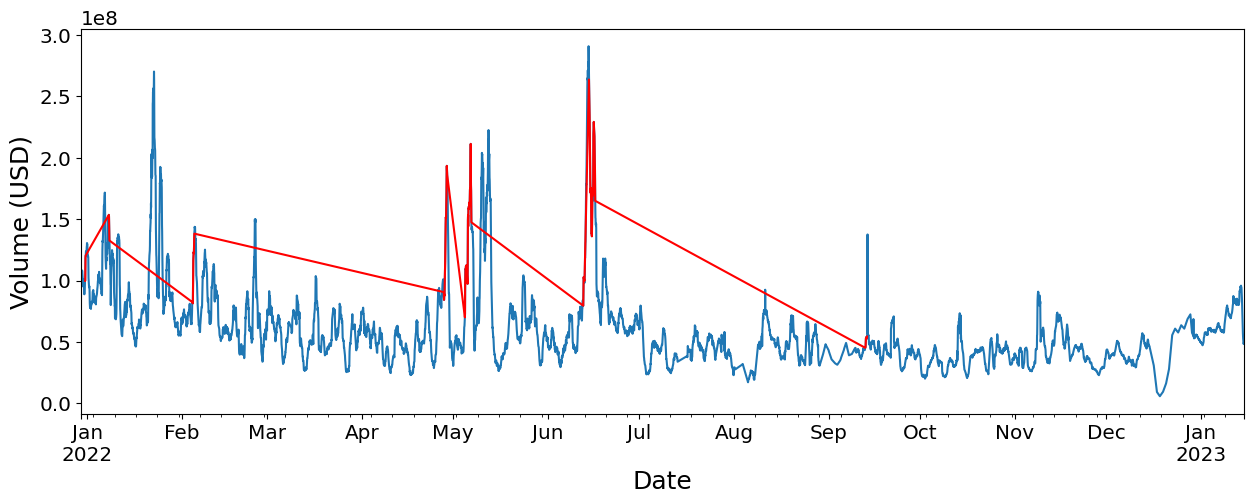

<Figure size 1500x1000 with 0 Axes>

upbit

207
percentage of anomalies: 1.6294838145231847





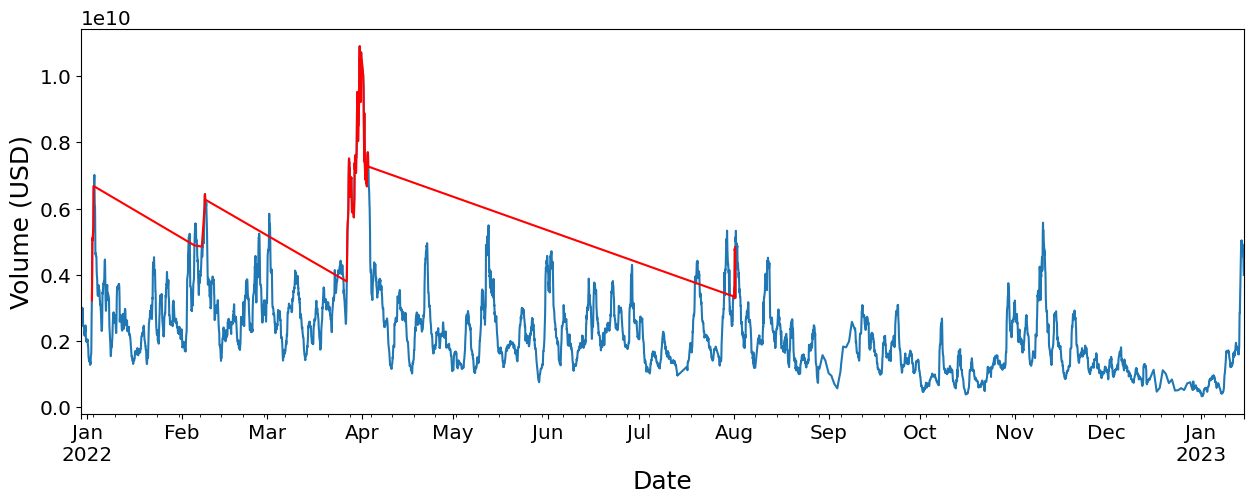

<Figure size 1500x1000 with 0 Axes>

whitebit

316
percentage of anomalies: 1.23578302712161





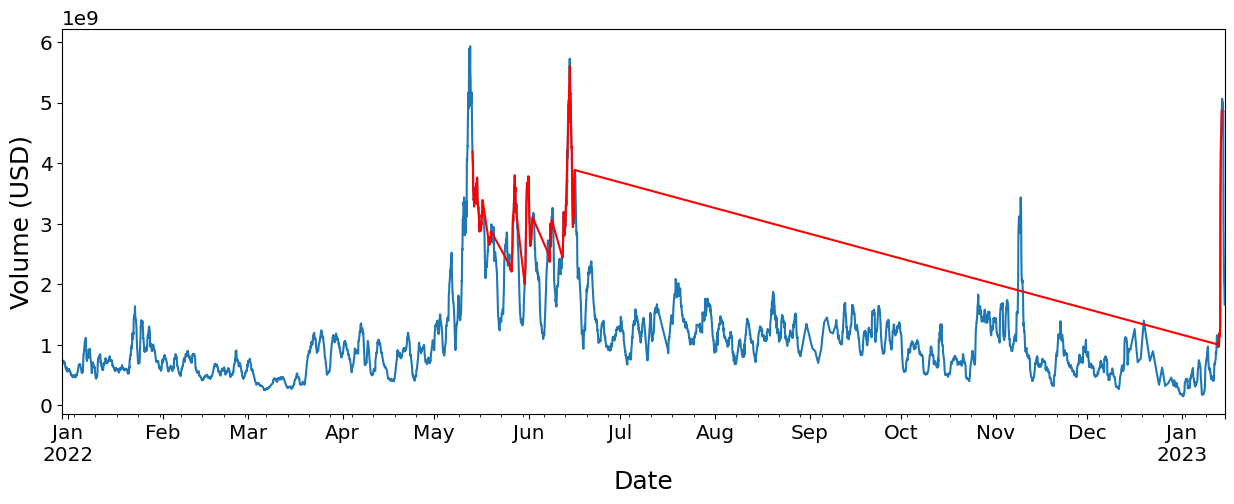

<Figure size 1500x1000 with 0 Axes>

baseline

3
percentage of anomalies: 0.0





In [18]:
all_ex = df_ts.columns.to_list()
#all_ex = ['binance']

for ex_id in all_ex:
    df_train = df_dict[ex_id][:240]
    print(ex_id+'\n')
    training_mean = df_train.mean()
    training_std = df_train.std()
    df_training_value = (df_train - training_mean) / training_std
    
    x_train = create_sequences(df_training_value.values)
    model = create_model()
    history = fit_model(x_train, model)
    #plot_learning_curve(history)
    
    # Get train MAE loss.
    x_train_pred = model.predict(x_train, verbose=0)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

#     plt.hist(train_mae_loss, bins=50)
#     plt.xlabel("Train MAE loss")
#     plt.ylabel("No of samples")
#     plt.show()

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    
    #plot_reconstruction(x_train, x_train_pred)
#     fig, ax = plt.subplots()
#     df_dict[ex_id].plot(legend=False, ax=ax)
#     plt.show()

    # Create sequences from test values.
    training_mean = df_dict[ex_id].mean()
    training_std = df_dict[ex_id].std()
    df_test_value = (df_dict[ex_id] - training_mean) / training_std
    x_test = create_sequences(df_test_value.values)
    #print(x_test[0])
    #print("Test input shape: ", x_test.shape)

    # Get test MAE loss.
    x_test_pred = model.predict(x_test, verbose=0)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

#     plt.hist(test_mae_loss, bins=50)
#     plt.xlabel("test MAE loss")
#     plt.ylabel("No of samples")
#     plt.show()

    # Detect all the samples which are anomalies.
    anomalies = test_mae_loss > threshold 
    
    for i in range(len(anomalies)):
        if i in np.where(anomalies_baseline)[0]:
            anomalies[i] = False
        
    print(anomalies.sum())
    #print("Number of anomaly samples: ", np.sum(anomalies))
    #print("Indices of anomaly samples: ", np.where(anomalies))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data_indices = []
    for data_idx in range(TIME_STEPS - 1, len(df_dict[ex_id]) - TIME_STEPS + 1):
        if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    anomalous_data_indices = [x for x in anomalous_data_indices if x not in anomalous_data_indices_baseline]
    perc_anomalies = len(anomalous_data_indices)/len(df_dict[ex_id]/TIME_STEPS)*100
    print(f"percentage of anomalies: {perc_anomalies}\n\n\n")
    
    if (perc_anomalies > 0):
        df_subset = df_dict[ex_id].iloc[np.where(anomalies)]
        fig, ax = plt.subplots()
        df_dict[ex_id].plot(legend=False, ax=ax)
        df_subset.plot(legend=False, ax=ax, color="r")
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Volume (USD)', fontsize=18)
        params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
        plt.rcParams.update(params)
        fig.savefig('plot.jpg')
        plt.figure(figsize=(15,10))
        plt.show()

whitebit

325
percentage of anomalies: 1.7011340893929285



[3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3952, 3953, 3954, 3955, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025]


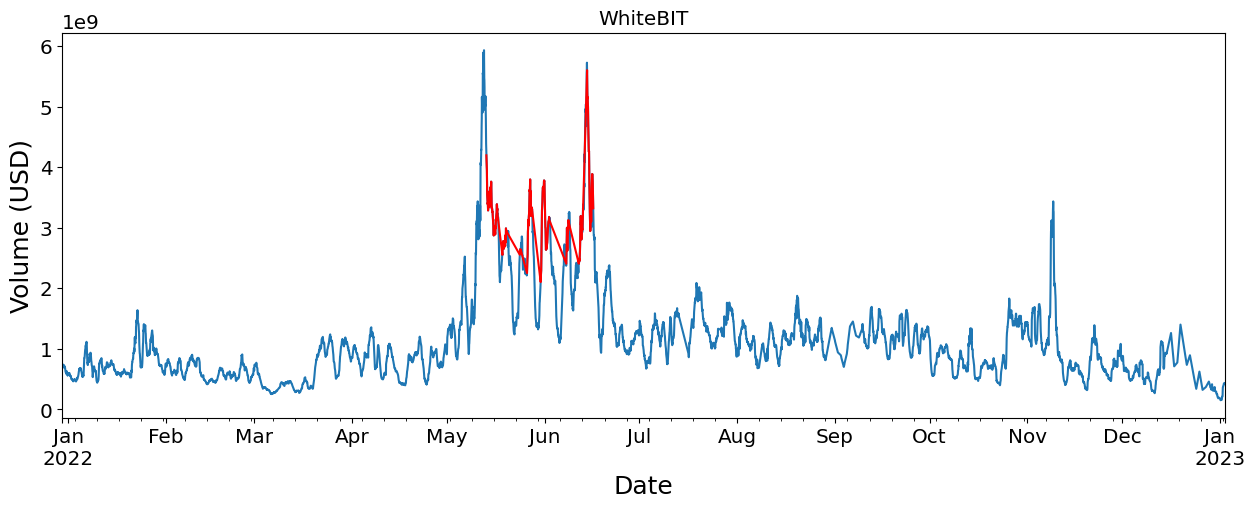

<Figure size 1500x1000 with 0 Axes>

In [54]:
#all_ex = df_ts.columns.to_list()
all_ex = ['whitebit']

for ex_id in all_ex:
    df_train = df_dict[ex_id][:240]
    print(ex_id+'\n')
    training_mean = df_train.mean()
    training_std = df_train.std()
    df_training_value = (df_train - training_mean) / training_std
    
    x_train = create_sequences(df_training_value.values)
    model = create_model()
    history = fit_model(x_train, model)
    #plot_learning_curve(history)
    
    # Get train MAE loss.
    x_train_pred = model.predict(x_train, verbose=0)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

#     plt.hist(train_mae_loss, bins=50)
#     plt.xlabel("Train MAE loss")
#     plt.ylabel("No of samples")
#     plt.show()

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    
    #plot_reconstruction(x_train, x_train_pred)
#     fig, ax = plt.subplots()
#     df_dict[ex_id].plot(legend=False, ax=ax)
#     plt.show()

    # Create sequences from test values.
    training_mean = df_dict[ex_id].mean()
    training_std = df_dict[ex_id].std()
    df_test_value = (df_dict[ex_id] - training_mean) / training_std
    x_test = create_sequences(df_test_value.values)
    #print(x_test[0])
    #print("Test input shape: ", x_test.shape)

    # Get test MAE loss.
    x_test_pred = model.predict(x_test, verbose=0)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

#     plt.hist(test_mae_loss, bins=50)
#     plt.xlabel("test MAE loss")
#     plt.ylabel("No of samples")
#     plt.show()

    # Detect all the samples which are anomalies.
    anomalies = test_mae_loss > threshold 
    
    for i in range(len(anomalies)):
        if i in np.where(anomalies_baseline)[0]:
            anomalies[i] = False
        
    print(anomalies.sum())
    #print("Number of anomaly samples: ", np.sum(anomalies))
    #print("Indices of anomaly samples: ", np.where(anomalies))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data_indices = []
    for data_idx in range(TIME_STEPS - 1, len(df_dict[ex_id]) - TIME_STEPS + 1):
        if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    anomalous_data_indices = [x for x in anomalous_data_indices if x not in anomalous_data_indices_baseline]
    perc_anomalies = len(anomalous_data_indices)/len(df_dict[ex_id]/TIME_STEPS)*100
    print(f"percentage of anomalies: {perc_anomalies}\n\n\n")
    print(anomalous_data_indices)
    df_dict[ex_id] = df_dict[ex_id][:-150]
    if (perc_anomalies > 0):
        df_subset = df_dict[ex_id].iloc[np.where(anomalies)]
        fig, ax = plt.subplots()
        ax.set_title("WhiteBIT")
        df_dict[ex_id].plot(legend=False, ax=ax)
        df_subset.plot(legend=False, ax=ax, color="r")
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Volume (USD)', fontsize=18)
        params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
        plt.rcParams.update(params)
        fig.savefig('plot.jpg')
        plt.figure(figsize=(15,10))
        plt.show()